Trial 72 Complete [00h 00m 19s]
val_accuracy: 0.875

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 22m 43s
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.3685 - loss: 1.3374 - val_accuracy: 0.5417 - val_loss: 1.1132
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3151 - loss: 1.2815 - val_accuracy: 0.5417 - val_loss: 1.0989
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3398 - loss: 1.2288 - val_accuracy: 0.4583 - val_loss: 1.0957
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3750 - loss: 1.1962 - val_accuracy: 0.5000 - val_loss: 1.0944
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4284 - loss: 1.1831 - val_accuracy: 0.5833 - val_loss: 1.0868
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4557 - loss: 1.1521 - val_accuracy: 0.6250 - val_loss: 1.0698
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6328 - loss: 1.0923 - val_accuracy: 0.6250 - val_loss: 1.0483
Ep

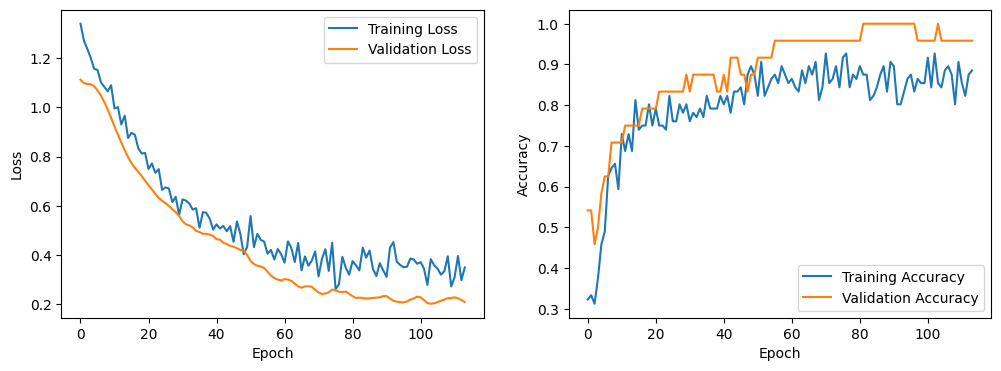

In [2]:
!pip install keras_tuner
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.initializers import HeNormal
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

def get_timestamp():
    return datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

def build_model(hp):
    model = Sequential()
    neurons_l1 = hp.Int('neurons_l1', min_value=4, max_value=6, step=1)
    neurons_l2 = hp.Int('neurons_l2', min_value=4, max_value=6, step=1)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.1)
    l2_lambda = hp.Choice('l2_lambda', values=[0.01, 0.001])
    learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001])
    model.add(Dense(neurons_l1, input_dim=4, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons_l2, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def save_plot(history, filename):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(filename)

def log_results(filename, tuning_time, training_time, execution_time, history, test_loss, test_accuracy, image_filename, best_hyperparameters):
    with open(filename, 'w') as f:
        f.write(f"Tuning Time: {tuning_time:.4f} seconds\n")
        f.write(f"Training Time: {training_time:.4f} seconds\n")
        f.write(f"Execution Time: {execution_time:.4f} seconds\n")
        f.write(f"Test Loss: {test_loss:.4f}\n")
        f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
        f.write(f"Image Filename: {image_filename}\n")
        f.write(f"Best Hyperparameters: {best_hyperparameters}\n")

def log_trial_results(trial_hyperparameters, val_accuracy, val_loss):
    with open("trial_results.txt", 'a') as f:
        f.write(f"Hyperparameters: {trial_hyperparameters}\n")
        f.write(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}\n")
        f.write("-"*50 + "\n")

iris = load_iris()
X = StandardScaler().fit_transform(iris.data)
Y = to_categorical(iris.target)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

start_tuning = time.time()
tuner = kt.GridSearch(
    build_model,
    objective='val_accuracy',
    max_trials=200,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='iris_grid_search'
)
tuner.search(X_train, Y_train, epochs=150, validation_split=0.2, verbose=1,
             callbacks=[TensorBoard(log_dir='logs')])
tuning_time = time.time() - start_tuning

# Guardar resultados de cada trial
for trial in tuner.oracle.trials.values():
    log_trial_results(trial.hyperparameters.values, trial.metrics.get_best_value("val_accuracy"), trial.metrics.get_best_value("val_loss"))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

start_training = time.time()
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = best_model.fit(X_train, Y_train, batch_size=32, epochs=200, validation_split=0.2, callbacks=[early_stop], verbose=1)
training_time = time.time() - start_training

start_execution = time.time()
test_loss, test_accuracy = best_model.evaluate(X_test, Y_test, verbose=0)
execution_time = time.time() - start_execution

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

timestamp = get_timestamp()
image_filename = f"{timestamp}.png"
log_filename = f"{timestamp}.txt"
save_plot(history, image_filename)
log_results(log_filename, tuning_time, training_time, execution_time, history, test_loss, test_accuracy, image_filename, best_hps.values)